In [1]:
    """extended python types for the web and json

    Example
    -------

    Notes
    -----
    Attributes
    ----------
    simpleTypes : list
        The limited set of base types provide by jsonschema.

    Todo
    ---
    * Configuration Files
    * Observable Pattern
    * You have to also use ``sphinx.ext.todo`` extension

    .. ``jsonschema`` documentation:
       https://json-schema.org/
    """
    __version__ = "0.0.1"

In [2]:
    import jsonschema, munch, typing, abc, inspect, dataclasses, copy, re
    class _NoTitle:...
    class _NoInit: 
        """Subclass this module to restrict initializing an object from the type."""
        def __new__(cls, *args, **kwargs):
            raise TypeError(F"Cannot initialize the type : {cls.__name__}")
    simpleTypes = jsonschema.Draft7Validator.META_SCHEMA['definitions']['simpleTypes']['enum']

In [3]:
    def istype(object, cls):
        "is the thing a type"
        if isinstance(object, type):
            return issubclass(object, cls)
        return False


    def get_schema(object):
        """infer a schema from an object."""
        if isinstance(object, typing.Hashable):
            if object == str: object = String
            elif object == tuple: object = List
            elif object == list: object = List
            elif object == dict: object = Dict
            elif object == int: object = Integer
            elif object == float: object = Float
            elif object == None: object = Null
            elif object == bool: object = Bool
                
        if hasattr(object, '_schema'):
            return object._schema            
        return object

    def object_to_webtype(object):
        if isinstance(object, typing.Mapping): return Dict
        if isinstance(object, str): return String
        if isinstance(object, typing.Sequence): return List
        if isinstance(object, bool): return Bool
        if isinstance(object, (int, float)): return Float
        if object == None: return Null
        return Trait


    def _lower_key(str): return str[0].lower()+str[1:]

## `webtypes` meta schema

In [4]:
    
    class _SchemaMeta(abc.ABCMeta):
        """A metaclass for a constrained type system based on ``jsonschema``.
        
    The ``_SchemaMeta`` ensures that a type's extended schema is validate.
    Types cannot be generated with invalid schema.

    Attributes
    ----------
    _meta_schema : dict
        The schema the type system validates against.
        
    _schema : dict
        The schema the object validates against.
    
    _type
        The resource type.

    """

        _meta_schema = jsonschema.Draft7Validator.META_SCHEMA
        _schema = None
        _type = "http://json-schema.org/draft-07/schema#/properties/"
        
        def _merge_annotations(cls):
            """Merge annotations from the module resolution order."""
            if not hasattr(cls, '__annotations__'): cls.__annotations__ = {}
            for module in reversed(type(cls).__mro__):
                cls.__annotations__.update(getattr(module, '__annotations__', {}))
        
        def _merge_schema(cls):
            """Merge schema from the module resolution order."""
            schema = munch.Munch()
            for self in reversed(cls.__mro__):
                schema.update(munch.Munch.fromDict(getattr(self, '_schema', {}) or {}))
            cls._schema = schema
            
        def __new__(cls, name, base, kwargs, **schema):
            global simpleTypes
            
                
            cls = super().__new__(cls, name, base, kwargs)
            cls._type = schema.pop('type', None) or cls._type
            # Combine metadata across the module resolution order.
            cls._merge_annotations(), cls._merge_schema()
            if schema.get('type', 'null') not in simpleTypes:
                cls._type = schema.pop('type')
            cls._schema.update(schema)
            
            jsonschema.validate(cls._schema, cls._meta_schema, format_checker=jsonschema.draft7_format_checker)
            """Validate the proposed schema against the jsonschema schema."""
            return cls
        
        def create(cls, name: str, **schema):
            """Create a new schema type.
    
    Parameters
    ----------
    name: str
        The title of the new type/schema
    **schema: dict
        Extra features to add include in the schema.
        
    Returns
    -------
    type
        
            """
            return type(name, (cls,), {'_schema': copy.copy(cls._schema)}, **schema)
        
        def __neg__(cls): return Not[cls._schema]
        
        def __pos__(cls): return cls
        def __add__(cls, object): return cls.create(
            cls.__name__ + ("" if istype(object, _NoTitle) else object.__name__), **get_schema(object))
        
        def __and__(cls, object): return AllOf[cls, object]
        
        def __sub__(cls, object): return AnyOf[cls, object]
        
        def __or__(cls, object): return OneOf[cls, object]
        
        def validate(cls, object): 
            """Validate an object against type's schema.
            
    Note
    ----
    ``isinstance`` can used for validation, too.
    
    Parameters
    ----------
    object
        An object to validate.
            
    Raises
    ------
    jsonschema.ValidationError
        The ``jsonschema`` module validation throws an exception on failure,
        otherwise the returns a None type.
    """
            jsonschema.validate(object, cls._schema, format_checker=jsonschema.draft7_format_checker)
        
        def __instancecheck__(cls, object):
            try: return cls.validate(object) or True
            except: return False

        
    class _ConstType(_SchemaMeta): 
        """ConstType permits bracketed syntax for defining complex types.
                
    Note
    ----
    The bracketed notebook should differeniate actions on types versus those on objects.
    """

        def __getitem__(cls, object):
            if isinstance(object, tuple):
                object = list(object)
            return cls.create(cls.__name__, **{_lower_key(cls.__name__): object})

    class _ContainerType(_ConstType): 
        """ContainerType extras schema from bracketed arguments to define complex types."""

        def __getitem__(cls, object):
            schema_key = _lower_key(cls.__name__)
            if isinstance(object, type):
                object = get_schema(object)
            if isinstance(object, dict):
                object = {**cls._schema.get(schema_key, {}), **{k: get_schema(v) for k, v in object.items()}}
            if isinstance(object, tuple):
                object = cls._schema.get(schema_key, []) + list(map(get_schema, object))
            return cls + Trait.create(schema_key, **{schema_key: object})

In [5]:
    class Trait(metaclass=_SchemaMeta):
        """A trait is an object validated by a validate ``jsonschema``.
        """
        _schema = None
        _type = "http://www.w3.org/2000/01/rdf-schema#Resource"
        
        def __new__(cls, *args, **kwargs):
            """__new__ validates an object against the type schema and dispatches different values in return.
            
            
            
    Parameters
    ----------
    *args
        The arguments for the base object class.
    **kwargs
        The keyword arguments for the base object class.
        
    Returns
    -------
    object
        Return an instance of the object and carry along the schema information.
    """
            args and cls.validate(args[0])
            try: return super().__new__(cls, *args, **kwargs)
            except: return object_to_webtype(args[0])(args[0]) if args else Trait()
            return self
        

In [6]:
    class Description(_NoInit, Trait, _NoTitle, metaclass=_ConstType): 
        """An empty type with a description
        
        
    Examples
    --------
    
        >>> yo = Description['yo']
        >>> yo._schema.toDict()
        {'description': 'yo'}

        """
    class Examples(_NoInit, Trait, metaclass=_ConstType): 
        """"""
        
    class Title(_NoInit, Trait, _NoTitle, metaclass=_ConstType): 
        """An empty type with a title
        
        
    Examples
    --------
    
        >>> holla = Title['holla']
        >>> holla._schema.toDict()
        {'title': 'holla'}
        """

    class Const(_NoInit, Trait, metaclass=_ConstType): 
        """A constant
        
    Examples
    --------
    
        >>> Const[10]._schema.toDict()
        {'const': 10}
        
        
        >>> assert isinstance('thing', Const['thing'])
        >>> assert not isinstance('jawn', Const['thing']), "Because the compiler is from Philly."
        
    """

## Logical Types

In [7]:
    class Bool(Trait, metaclass=_SchemaMeta): 
        """Boolean types.
            
    Examples
    --------
    
        >>> Bool(), Bool(True), Bool(False)
        (False, True, False)
        
    Note
    ----
    It is not possible to base class ``bool`` so object creation is customized.
        
    """
        _schema = dict(type='boolean')

        def __new__(cls, *args):            
            args = args or (bool(),)
            args and cls.validate(args[0])
            return args[0]
        
    class Null(Trait, metaclass=_SchemaMeta): 
        """nil, none, null type
            
    Examples
    --------
    
        >>> Null(None)
        
    .. Null Type:
        https://json-schema.org/understanding-json-schema/reference/null.html
        
    """
        _schema = dict(type='null')
        
        def __new__(cls, *args):
            args and cls.validate(args[0])    

## Numeric Types

In [8]:
    class _NumericSchema(_SchemaMeta):
        """Meta operations for numerical types"""
        def __ge__(cls, object): 
            return cls + Minimum[object]
        def __gt__(cls, object): 
            return cls + ExclusiveMinimum[object]
        def __le__(cls, object): 
            return cls + Maximum[object]
        def __lt__(cls, object): return cls + ExclusiveMaximum[object]
        __rgt__ = __lt__
        __rge__ = __le__
        __rlt__ = __gt__
        __rle__ = __ge__
        def __truediv__(cls, object): return cls + MultipleOf[object]

    class Integer(Trait, int, metaclass=_NumericSchema):
        """integer type
        
        
    >>> assert isinstance(10, Float)
    
    Symbollic conditions.
    
        >>> bounded = (10< Float)< 100
        >>> bounded._schema.toDict()
        {'type': 'number', 'exclusiveMinimum': 10, 'exclusiveMaximum': 100}

        >>> assert isinstance(12, bounded)
        >>> assert not isinstance(0, bounded)

    Multiples
    
        >>> assert (Integer+MultipleOf[3])(9) == 9
    
    
    .. Numeric Types:
        https://json-schema.org/understanding-json-schema/reference/numeric.html
        
        """
        _schema = dict(type='integer')
        

    class Float(Trait, float, metaclass=_NumericSchema):
        """float type
        
        
        >>> assert isinstance(10, Integer)
        >>> assert not isinstance(10.1, Integer)

        >>> bounded = (10< Float)< 100
        >>> bounded._schema.toDict()
        {'type': 'number', 'exclusiveMinimum': 10, 'exclusiveMaximum': 100}

        >>> assert isinstance(12, bounded)
        >>> assert not isinstance(0, bounded)
        >>> assert (Integer/3)(9) == 9
        
        """
        _schema = dict(type='number')
        
    class MultipleOf(_NoInit, Trait, metaclass=_ConstType): 
        """A multipleof constraint for numeric types."""
    class Minimum(_NoInit, Trait, metaclass=_ConstType): 
        """A minimum constraint for numeric types."""
    class ExclusiveMinimum(_NoInit, Trait, metaclass=_ConstType):
        """A exclusive minimum constraint for numeric types."""
    class Maximum(_NoInit, Trait, metaclass=_ConstType): 
        """A exclusive maximum constraint for numeric types."""
    class ExclusiveMaximum(_NoInit, Trait, metaclass=_ConstType):
        """A exclusive maximum constraint for numeric types."""

## Mapping types

In [9]:
    class Properties(Trait, _NoInit, _NoTitle,metaclass=_ContainerType): 
        """Object properties."""
    
    class _ObjectSchema(_SchemaMeta):
        """Meta operations for the object schema."""
        def __getitem__(cls, object):
            if isinstance(object, dict):
                return cls + Properties[object]
            if not isinstance(object, tuple):
                object = object,
            return cls + AdditionalProperties[AnyOf[object]]
            
            
        
    class _Object(metaclass=_ObjectSchema): 
        """Base class for validating object types."""
        _schema = dict(type='object')
        def __init_subclass__(cls, **kwargs): 
            cls._schema = copy.copy(cls._schema)
            cls._schema.update(kwargs)
            cls._schema.update(Properties[cls.__annotations__]._schema)
    
    class Dict(Trait, dict, _Object): 
        """dict type
        
    Examples
    --------
    
        >>> assert isinstance({}, Dict)
        >>> assert not isinstance([], Dict)
        
        >>> assert isinstance({'a': 1}, Dict + Required['a',])
        >>> assert not isinstance({}, Dict + Required['a',])

        >>> assert not isinstance({'a': 'b'}, Dict[Integer, Float])
        >>> assert Dict[Integer]({'a': 1}) == {'a': 1}
        
    .. Object Type
        https://json-schema.org/understanding-json-schema/reference/object.html
        """
        __annotations__ = {}
        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs), type(self).validate(self)

    class Bunch(munch.Munch, Dict): 
        """Bunch type
        
        
    .. Munch Documentation
        https://pypi.org/project/munch/
        
    """
    class DataClass(Trait, _Object):
        """Validating dataclass type"""
        def __init_subclass__(cls, **kwargs): 
            cls._schema.update(Properties[cls.__annotations__]._schema)
            dataclasses.dataclass(cls)
        def __post_init__(self):
            type(self).validate(vars(self))         
            
            
    class AdditionalProperties(Trait, _NoInit, _NoTitle, metaclass=_ContainerType): 
        """Additional object properties."""
    class Required(Trait, _NoInit, _NoTitle, metaclass=_ContainerType):
        """Required properties."""
    class minProperties(Trait, _NoInit, _NoTitle, metaclass=_ConstType): 
        """Minimum number of properties."""
    class maxProperties(Trait, _NoInit, _NoTitle, metaclass=_ConstType): 
        """Maximum number of properties."""
    class PropertyNames(Trait, _NoInit, _NoTitle, metaclass=_ConstType): 
        """Propery name constraints."""
    class Dependencies(Trait, _NoInit, _NoTitle, metaclass=_ConstType): 
        """Properties dependencies."""
    class PatternProperties(Trait, _NoInit, _NoTitle, metaclass=_ContainerType): 
        """Pattern properties names."""

## String Type

In [10]:
    class _StringSchema(_SchemaMeta):
        """Meta operations for strings types.
        
        """
        def __mod__(cls, object):
            return cls + Pattern[object]
        def __gt__(cls, object): 
            return cls + MinLength[object]
        def __lt__(cls, object): 
            return cls + MaxLength[object]
        __rgt__ = __rge__ = __le__ = __lt__
        __rlt__ = __rle__ = __ge__ = __gt__

        
    class String(Trait, str, metaclass=_StringSchema): 
        """string type.
        
        
    Examples
    --------
    
        >>> assert isinstance('abc', String)
        
    String patterns
    
        >>> assert isinstance('abc', String%"^a")
        >>> assert not isinstance('abc', String%"^b")
        
    String constraints
        
        >>> assert isinstance('abc', (2<String)<10) 
        >>> assert not isinstance('a', (2<String)<10)
        >>> assert not isinstance('a'*100, (2<String)<10)
        """
        _schema = dict(type='string')
    class MinLength(Trait, _NoInit, _NoTitle, metaclass=_ConstType): 
        """Minimum length of a string type."""
    class MaxLength(Trait, _NoInit, _NoTitle, metaclass=_ConstType): 
        """Maximum length of a string type."""
    class ContentMediaType(Trait, _NoInit, _NoTitle, metaclass=_ConstType): 
        """Content type of a string."""
    class Pattern(Trait, _NoInit, metaclass=_ConstType): 
        """A regular expression pattern."""

## Array Type

In [11]:
    class _ListSchema(_SchemaMeta):
        """Meta operations for list types."""
        def __getitem__(cls, object): 
            if isinstance(object, tuple):
                return cls + Items[AnyOf[object]]
            return cls + Items[object]

    class List(Trait, list, metaclass=_ListSchema): 
        """List type
        
        
    Examples
    --------
    
    List
    
        >>> assert isinstance([], List)
        >>> assert not isinstance({}, List)
        
    Typed list
    
        >>> assert isinstance([1], List[Integer])
        >>> assert not isinstance([1.1], List[Integer])
        
    Tuple        
        
        >>> assert isinstance([1, '1'], List[Integer, String])
        >>> assert not isinstance([1, {}], List[Integer, String])
        """
        _schema = dict(type='array')

    class Unique(List, uniqueItems=True):
        """Unique list type
        
        
    Examples
    --------
    
        >>> assert isinstance([1,2], Unique)
        >>> assert not isinstance([1,1], Unique)
        
        """
        
    class _TupleSchema(_SchemaMeta):
        """Meta operations for list types."""
        def __getitem__(cls, object): 
            if not isinstance(object, tuple):
                object = object,
            return cls + Items[object]
    
    class Tuple(Trait, metaclass=_TupleSchema): 
        """tuple type
        
    Note
    ----
    There are no tuples in json, they are typed lists.
    
        >>> assert Tuple._schema == List._schema
        
        
    Examples
    --------
    
        >>> assert isinstance([1,2], Tuple)
        >>> assert isinstance([1,'1'], Tuple[Integer, String])
        >>> assert not isinstance([1,1], Tuple[Integer, String])
        
        """
        _schema = dict(type='array')
        
        
    class UniqueItems(Trait, _NoInit, _NoTitle, metaclass=_ConstType): 
        """Schema for unique items in a list."""
    class Contains(Trait, _NoInit, _NoTitle, metaclass=_ContainerType): ...
    class Items(Trait, _NoInit, _NoTitle, metaclass=_ContainerType): ...
    class AdditionalItems(Trait, _NoInit, _NoTitle, metaclass=_ContainerType): ...
    
    

## Combining Schema

In [12]:
    class Not(Trait, _NoInit, metaclass=_ContainerType): 
        """not schema.
        
    
    Examples
    --------
        
        >>> assert Not[String](100) == 100   
        >>> assert not isinstance('abc', Not[String])
        
    Note
    ----
    .. Not
        https://json-schema.org/understanding-json-schema/reference/combining.html#not
    """
    class AnyOf(Trait, _NoInit, metaclass=_ContainerType):
        """anyOf combined schema.
        
    Examples
    --------
    
        >>> assert isinstance(10, AnyOf[Integer, String])
        >>> assert not isinstance([], AnyOf[Integer, String])
        
    .. anyOf
        https://json-schema.org/understanding-json-schema/reference/combining.html#anyof
    """
    class AllOf(Trait, _NoInit, metaclass=_ContainerType): 
        """allOf combined schema.
        
    Examples
    --------
    
        >>> assert isinstance(9, AllOf[Float>0, Integer/3])
        >>> assert not isinstance(-9, AllOf[Float>0, Integer/3])
        
    .. allOf
        https://json-schema.org/understanding-json-schema/reference/combining.html#allof
    """

    class OneOf(Trait, _NoInit, metaclass=_ContainerType): 
        """oneOf combined schema.
    
    Examples
    --------
    
        >>> assert isinstance(-9, OneOf[Float>0, Integer/3])
        >>> assert not isinstance(9, OneOf[Float>0, Integer/3])

        
    .. oneOf
        https://json-schema.org/understanding-json-schema/reference/combining.html#oneof
    """

    class Enum(Trait, _NoInit, metaclass=_ConstType): 
        """An enumerate type that is restricted to its inputs.
        
        
    Examples
    --------
    
        >>> assert isinstance('cat', Enum['cat', 'dog'])
        >>> assert not isinstance('🐢', Enum['cat', 'dog'])
    
        
        """

## String Formats

In [13]:
    class ContentEncoding(Enum['7bit 8bit binary quoted-printable base64'.split()], _NoInit, _NoTitle): 
        """Content encodings for a string.
        
    .. Json schema media:
        https://json-schema.org/understanding-json-schema/reference/non_json_data.html
    """
    
    class Format(Enum['color date-time time date email idn-email hostname idn-hostname ipv4 ipv6 \
    uri uri-reference iri iri-reference uri-template json-pointer relative-json-pointer regex'.split()], _NoInit, _NoTitle): ...

    for key in Format._schema.enum:
        locals()[key.capitalize()] = String + Format[key]
    Regex.compile = re.compile
    del key

In [14]:
    class If(Trait, metaclass=_ContainerType): ...
    class Then(Trait, metaclass=_ContainerType): ...
    class Else(Trait, metaclass=_ContainerType): ...

[NbConvertApp] Converting notebook wtypes.ipynb to python
[NbConvertApp] Writing 19975 bytes to wtypes.py
Fixing /Users/tonyfast/webtypes/wtypes.py
]0;IPython: tonyfast/webtypesTestResults(failed=0, attempted=56)
Name                                                        Stmts   Miss  Cover
-------------------------------------------------------------------------------
/Users/tonyfast/.local/lib/python3.7/site-packages/six.py     472    433     8%
wtypes.py                                                     269     44    84%
-------------------------------------------------------------------------------
TOTAL                                                         741    477    36%


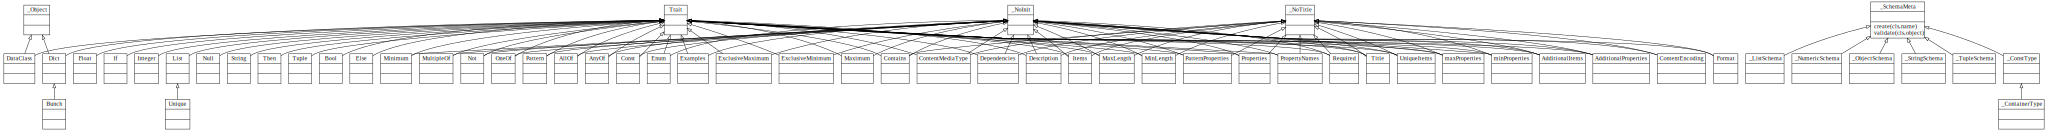

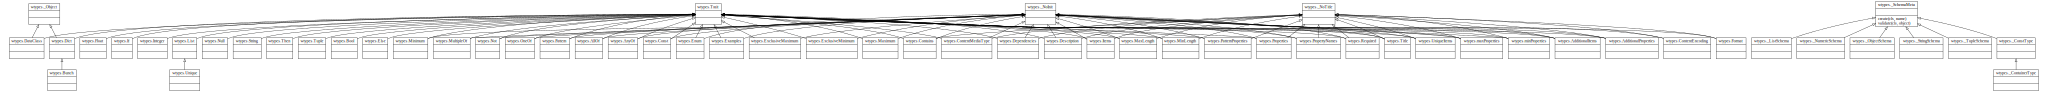

In [15]:
    if __name__ == "__main__":
        if "__file__" in locals():
            if "covtest" in __import__("sys").argv:
                print(__import__("doctest").testmod(optionflags=8))
        else:
            import IPython

            get_ipython().system(
                "jupyter nbconvert --to python --TemplateExporter.exclude_input_prompt=True wtypes.ipynb"
            )
            with IPython.utils.capture.capture_output():
                get_ipython().system("black wtypes.py")
            get_ipython().system("isort wtypes.py")
            get_ipython().system("ipython -m coverage -- run wtypes.py covtest")
            get_ipython().system("coverage report")
            get_ipython().system("coverage html")
            with IPython.utils.capture.capture_output():
                get_ipython().system("pyreverse wtypes -osvg -pwtypes")
            IPython.display.display(IPython.display.SVG("classes_wtypes.svg"))
            with IPython.utils.capture.capture_output():
                get_ipython().system("pyreverse wtypes -osvg -pwtypes -my -s1")
            IPython.display.display(IPython.display.SVG("classes_wtypes.svg"))